In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score,roc_curve,f1_score,accuracy_score
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import warnings
import statsmodels.api as sm

warnings.filterwarnings("ignore")



df = pd.read_csv('C:/regular/hmda/hmda.txt',delimiter='\t')
print(df.isnull().sum())
print(df.duplicated().sum())
print(df.nunique())



seq        0
s3         0
s4         0
s5         0
s6         0
          ..
vr         0
school     0
chval      0
dnotown    0
dprop      0
Length: 62, dtype: int64
0
seq        2380
s3            1
s4            1
s5            3
s6          302
           ... 
vr            2
school       27
chval       474
dnotown       2
dprop         1
Length: 62, dtype: int64


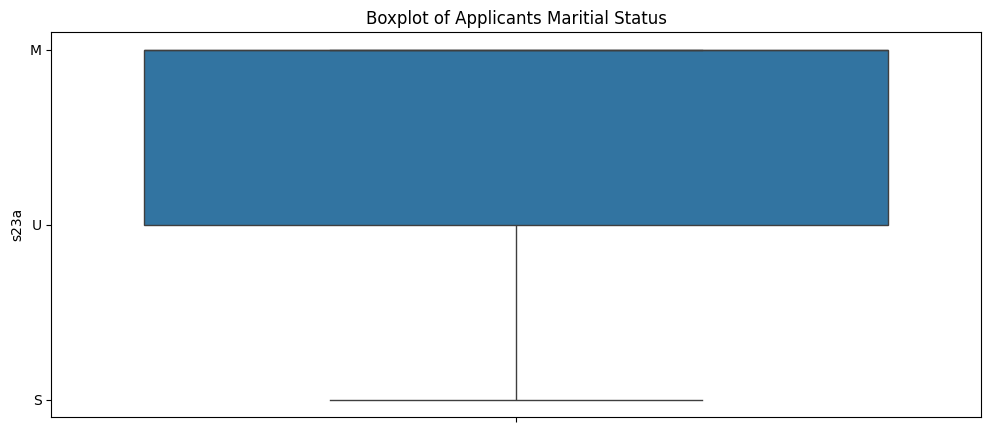

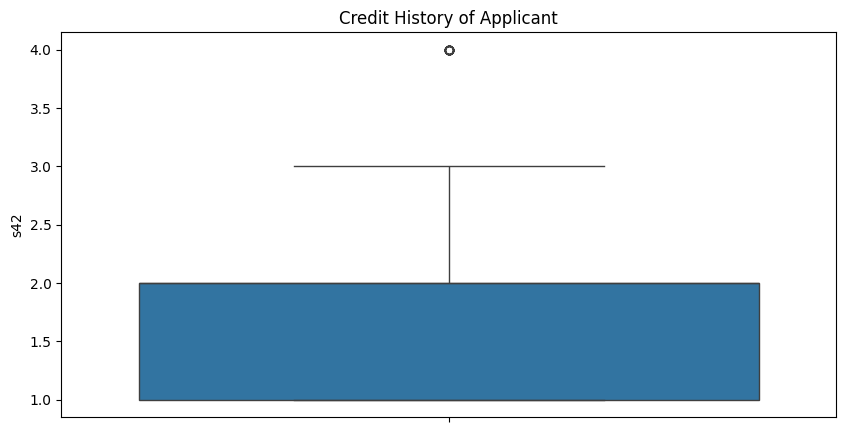

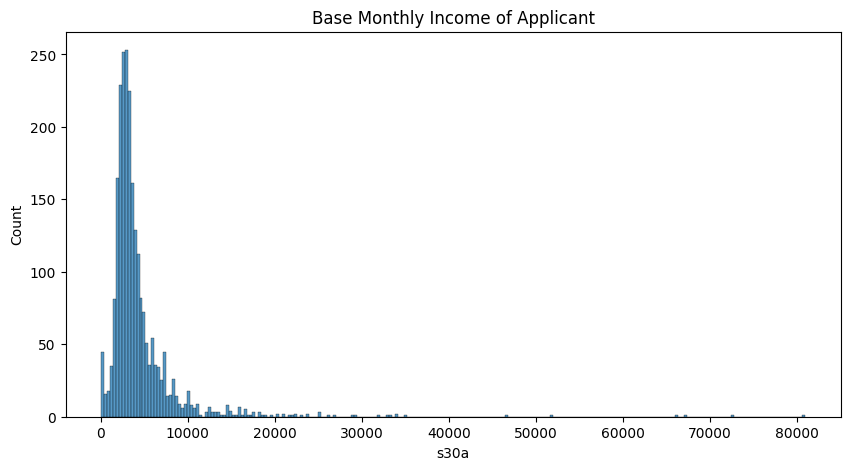

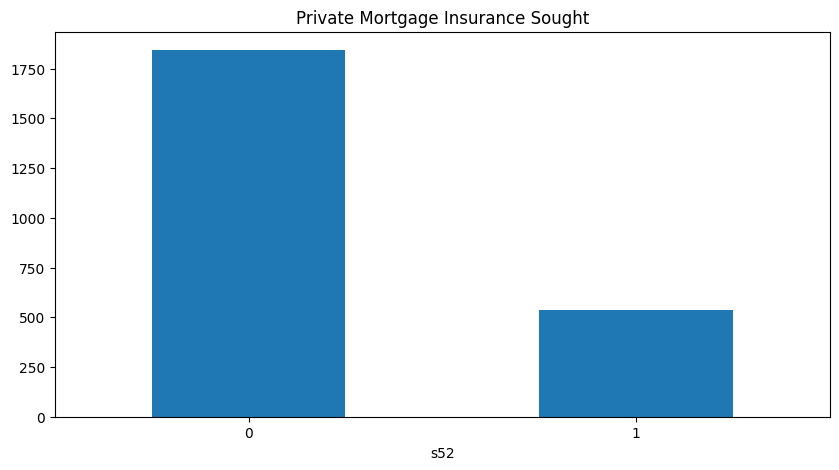

In [2]:


plt.figure(figsize=(12,5))
sns.boxplot(df['s23a'])
plt.title("Boxplot of Applicants Maritial Status")
plt.show()


plt.figure(figsize=(10,5))
sns.boxplot(df['s42'])
plt.title("Credit History of Applicant")
plt.show()


plt.figure(figsize=(10,5))
sns.histplot(df['s30a'])
plt.title("Base Monthly Income of Applicant")
plt.show()

plt.figure(figsize=(10,5))
df['s52'].value_counts().plot(kind='bar',rot=0)
plt.title("Private Mortgage Insurance Sought")
plt.show()

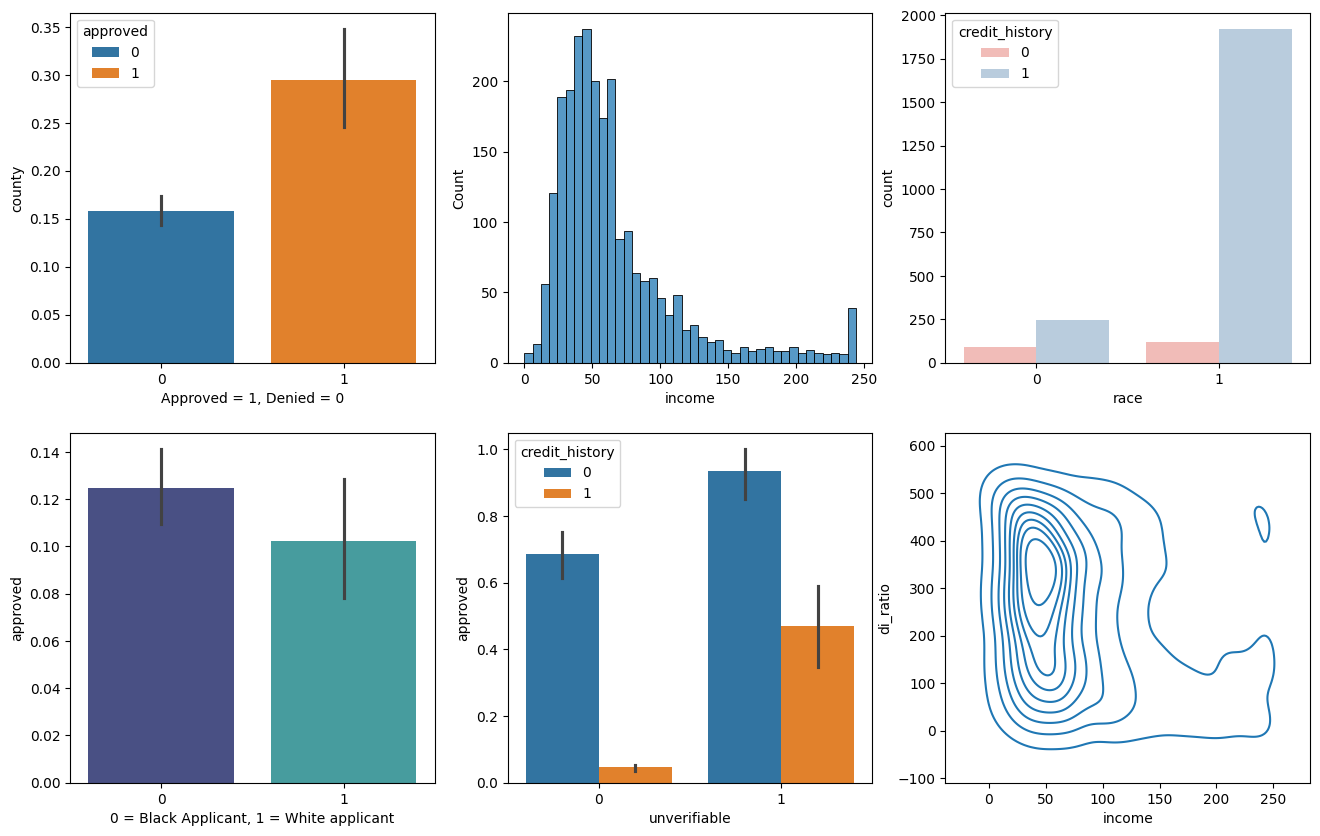

In [3]:

df.rename(columns={'s5':'occupancy','s7':'approve','s11':'county','s13':'race',
                   's15':'sex','s17':'income','s23a':'married','s27a':'self_employed',
                   's33':'purchase_price','s34':'other_financing','s35':'liquid_assets',
                   's40':'credit_history','s42':'chmp','s43':'chcp','s44':'chpr',
                   's45':'debt_to_expense','s46':'di_ratio','s50':'appraisal',
                   's53':'pmi_denied','netw':'net_worth','uria':'unemployment',
                   'school':'education','s56':'unverifiable',
                   's52':'pmi_sought'},inplace=True)













df['approved'] = [1 if X == 3 else 0 for X in df['approve']]
df['race'] = [0 if X == 3 else 1 for X in df['race']]
df['married'] = [1 if X == 'M' else 0 for X in df['married']]
df['sex'] = [1 if X == 1 else 0 for X in df['sex']]
df['credit_history'] = [1 if X == 1 else 0 for X in df['credit_history']]







features = ['occupancy','race','sex','income','married','credit_history','di_ratio',
            'pmi_denied','unverifiable','pmi_sought']


df1 = df.copy()
for i in df1:
    df1[i] = LabelEncoder().fit_transform(df1[i])





def subplots(df,df1):
    fig,axs = plt.subplots(2,3,figsize=(16,10))
    sns.barplot(x='approved',y='county',ax=axs[0,0],data=df,hue='approved')
    axs[0,0].set_label('approved VS county(Suffolk)')
    axs[0,0].set_xlabel('Approved = 1, Denied = 0')
    sns.histplot(x='income',ax=axs[0,1],data=df1)
    axs[0,1].set_label('Histogram of distribution of income')
    sns.countplot(x='race',ax=axs[0,2],data=df,hue='credit_history',palette='Pastel1')
    axs[1,0].set_xlabel('0 = Black Applicant, 1 = White applicant')
    sns.barplot(x='pmi_sought',y='approved',ax=axs[1,0],data=df,palette='mako')
    sns.barplot(x='unverifiable',y='approved',ax=axs[1,1],data=df,hue='credit_history')
    sns.kdeplot(x='income',y='di_ratio',ax=axs[1,2],data=df1)
    plt.show()


subplots(df,df1)

In [4]:

X = df[features]
y = df['approved']


model = sm.OLS(exog=sm.add_constant(X),endog=y).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               approved   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     226.3
Date:                Fri, 07 Feb 2025   Prob (F-statistic):               0.00
Time:                        19:37:55   Log-Likelihood:                 98.187
No. Observations:                2380   AIC:                            -174.4
Df Residuals:                    2369   BIC:                            -110.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.4663      0.036     12.

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)


scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



def evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test):
    model.fit(X_train_scaled, y_train)
    pred = model.predict(X_test_scaled)
    pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc = roc_auc_score(y_test, pred_prob)
    
    return model.__class__.__name__, acc * 100, roc * 100, f1 * 100





models = {
    "LogisticRegregression":LogisticRegression(),
    "BaggingClassifier":BaggingClassifier(),
    "RandomForestClassifier":RandomForestClassifier(),
    "GradientBoostingClassifier":GradientBoostingClassifier(),
    "KNN":KNeighborsClassifier(),
    "DecisionTreeClassifier":DecisionTreeClassifier(),
    "svc":SVC(probability=True)
    }


for name, model in models.items():
    model_name, acc, roc, f1 = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    print(f'{model_name} -- Accuracy: {acc:.2f}%, ROC AUC: {roc:.2f}%, F1: {f1:.2f}%')


LogisticRegression -- Accuracy: 94.75%, ROC AUC: 91.82%, F1: 75.25%
BaggingClassifier -- Accuracy: 93.07%, ROC AUC: 89.86%, F1: 67.96%
RandomForestClassifier -- Accuracy: 94.33%, ROC AUC: 90.77%, F1: 74.29%
GradientBoostingClassifier -- Accuracy: 93.28%, ROC AUC: 91.13%, F1: 68.63%
KNeighborsClassifier -- Accuracy: 93.28%, ROC AUC: 89.83%, F1: 68.63%
DecisionTreeClassifier -- Accuracy: 92.23%, ROC AUC: 82.63%, F1: 68.38%
SVC -- Accuracy: 94.33%, ROC AUC: 90.82%, F1: 74.29%


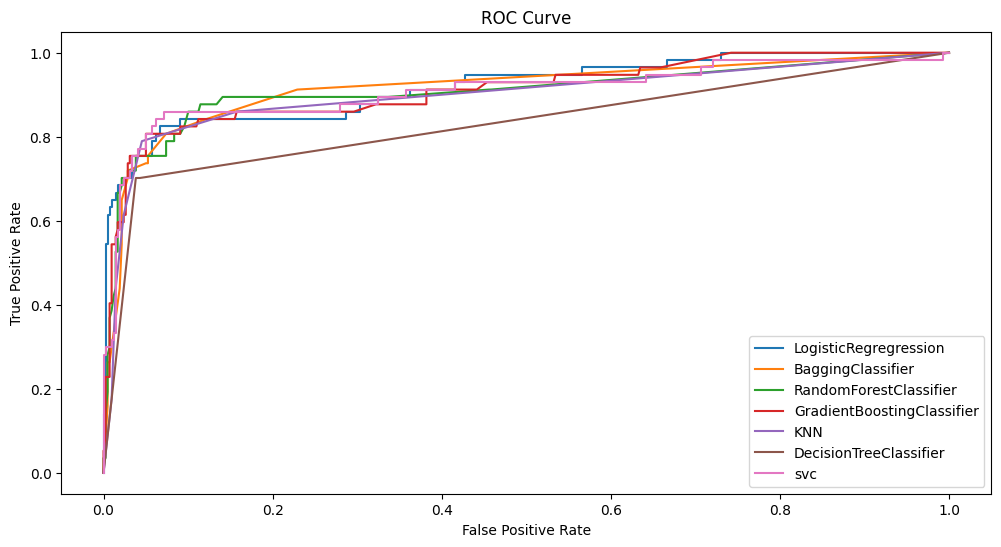

In [6]:

def plot_roc_curve(models, X_test_scaled, y_test):
    plt.figure(figsize=(12,6))
    
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        pred_prob = model.predict_proba(X_test_scaled)[:,1]
        fpr, tpr, _ = roc_curve(y_test, pred_prob)
        plt.plot(fpr, tpr, label=name)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()



plot_roc_curve(models, X_test_scaled, y_test)

In [8]:
#GridSearchCV for Logistic Regression Model

lr_param_grid = {'C': [0.001,0.01,0.1,1,10,100]}
lr_grid = GridSearchCV(LogisticRegression(),param_grid=lr_param_grid,scoring='roc_auc',cv=10).fit(X_train_scaled,y_train)
lr_grid_pred = lr_grid.best_estimator_.predict(X_test_scaled)
lr_grid_pred_prob = lr_grid.best_estimator_.predict_proba(X_test_scaled)[:,1]
print(f'Best ROC AUC score: {lr_grid.best_score_*100:.2f}%')
print('Predicted', np.round(lr_grid_pred_prob*100,2).max())



#Random Forest Gridsearch


rfc_param_grid = {
    'n_estimators': [10,50,100,200],
    'max_depth': [None,10],
    'min_samples_split':[2,5],
    'min_samples_leaf': [1,2]
}

rfc_grid = GridSearchCV(RandomForestClassifier(),param_grid=rfc_param_grid,scoring='roc_auc',cv=10).fit(X_train_scaled,y_train)
rfc_grid_pred = rfc_grid.best_estimator_.predict(X_test_scaled)
rfc_grid_pred_prob = rfc_grid.best_estimator_.predict_proba(X_test_scaled)[:,1]
print(f'Best ROC AUC score for Random Forest: {rfc_grid.best_score_*100:.2f}%')
print('Predicted',np.round(rfc_grid_pred_prob*100,2).max())


#Gradient Boost GridSearch

gbc_param_grid = {
    'n_estimators':[10,50,100,200],
    'learning_rate':[0.01,0.1],
    'max_depth':[3,5],
    'min_samples_split':[2,5]
}
gbc_grid = GridSearchCV(GradientBoostingClassifier(), param_grid=gbc_param_grid, scoring='roc_auc', cv=10).fit(X_train_scaled,y_train)
gbc_grid_pred = gbc_grid.best_estimator_.predict(X_test_scaled)
gbc_grid_pred_prob = gbc_grid.best_estimator_.predict_proba(X_test_scaled)[:,1]
print(f'Best ROC AUC score for Gradient Boosting: {gbc_grid.best_score_*100:.2f}%')
print('Predicted', np.round(gbc_grid_pred_prob*100,2).max())



# Support Vector Machine GridSearch

svc_param_grid ={'C':[0.001,0.01,0.1,1,10,100],'gamma':['scale', 'auto']}
svc_grid = GridSearchCV(SVC(probability=True),param_grid=svc_param_grid,scoring='roc_auc',cv=10).fit(X_train,y_train)
svc_grid_pred = svc_grid.best_estimator_.predict(X_test_scaled)
svc_grid_pred_prob = svc_grid.best_estimator_.predict_proba(X_test_scaled)[:,1]
print(f'Best ROC AUC score for Support Vector Machine: {svc_grid.best_score_*100:.2f}%')
print('Predicted', np.round(svc_grid_pred_prob*100,2).max())


# K-Nearest Neighbors


knn_param_grid = {'n_neighbors':[3,5,7],'p':[1,2]}
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid=knn_param_grid,scoring='roc_auc',cv=10).fit(X_train_scaled,y_train)
knn_grid_pred = knn_grid.best_estimator_.predict(X_test_scaled)
knn_grid_pred_prob = knn_grid.best_estimator_.predict_proba(X_test_scaled)[:,1]
print(f'Best ROC AUC score for K-Nearest Neighbors: {knn_grid.best_score_*100:.2f}%')
print('Predicted', np.round(knn_grid_pred_prob*100,2).max())


# Bagging Classifier GridSearch

BC_param_grid = {
    'n_estimators': [10,50,100],
    'max_samples': [0.5,0.7,1.0],
}



BC_grid = GridSearchCV(BaggingClassifier(),param_grid=BC_param_grid,scoring='roc_auc',cv=10).fit(X_train_scaled,y_train)
BC_grid_pred = BC_grid.best_estimator_.predict(X_test_scaled)
BC_grid_pred_prob = BC_grid.best_estimator_.predict_proba(X_test_scaled)[:,1]
print(f'Bagging Classifier - Best Parameters: {BC_grid.best_params_}')
print(f'Bagging Classifier - Best ROC-AUC Score: {BC_grid.best_score_ * 100:.2f}%')


#for decision tree classifier

dt_param_grid = {
    'criterion': ['gini','entropy'],
    'max_depth': [None,10,20,30],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4]
}


dt_grid =GridSearchCV(DecisionTreeClassifier(), dt_param_grid,scoring='roc_auc',cv=10).fit(X_train_scaled,y_train)
dt_grid_pred = dt_grid.best_estimator_.predict(X_test_scaled)
dt_grid_pred_prob = dt_grid.best_estimator_.predict_proba(X_test_scaled)[:,1]
print(f'Decision Tree Classifier - Best Parameters: {dt_grid.best_params_}')
print(f'Decision Tree Classifier - Best ROC-AUC Score: {dt_grid.best_score_ * 100:.2f}%')

Best ROC AUC score: 91.52%
Predicted 100.0
Best ROC AUC score for Random Forest: 90.83%
Predicted 95.93
Best ROC AUC score for Gradient Boosting: 91.36%
Predicted 99.28
Best ROC AUC score for Support Vector Machine: 78.24%
Predicted 18.99
Best ROC AUC score for K-Nearest Neighbors: 86.32%
Predicted 100.0
Bagging Classifier - Best Parameters: {'max_samples': 0.5, 'n_estimators': 50}
Bagging Classifier - Best ROC-AUC Score: 86.97%
Decision Tree Classifier - Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Decision Tree Classifier - Best ROC-AUC Score: 85.27%
